# Quantitative Multifactor Investing

## 1.	Abstract
> We build quantitative models for China A stock market by constructing return prediction factors using various Machine Learning algorithms. The nature of our multifactor model is a multiple linear regression about current factor exposures and future stock returns. In the end of this report, models will be explored to develop several trading strategies which all outperform the benchmark index from January 2015 to December 2019.

# 2. Introduction
> As of October 2020, the total value of China’s stock market has climbed to a record high of more than USD 10 trillion (RMB 67 trillion), making it the second-largest in the world, after the US at nearly USD 39 trillion.  

> The gigantic market volume makes Chinese stock market attractive for academic research and allows us to explore financial questions that contribute to our understandings of the quantitative finance area. 

> In particular, we successfully identify at least two key characteristics of the Chinese stock market. First, simple linear models are losing effectiveness in recent years. Second, our long-short strategy, if available, perform much better than the long-only one.
Moreover, our quantitative multifactor model consists of three parts below:
> + **Data**: This part contains data preprocess such as standardization, neutralization and extreme value removement, features creation, one-hot coding, etc..
> + **Model & prediction**: We will construct our model here and then start rolling trainings by predicting the return rates monthly with different parameters.
> + **Trading Strategy**: According to the stock prediction result, we design specific trading strategies and visualize relevant back-testing.


# 3. Coding Part

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

from sklearn import linear_model
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import tree
from sklearn import ensemble

import matplotlib.ticker as ticker
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei' 
plt.rcParams['axes.unicode_minus'] = False

from tqdm import trange # time

In [35]:
# ------- Model basic parameters --------- # 
# starting month
epoch_t0 = 201501 # 60 months of prediction till 202012

# training set len (per month)
len_train = 12 # 12 months



# ------- Data preprosess parameters ------- #

# Industry Neutralization: 
if_industry_neutral = 'idstn'   # variable for industry neutralization



colors = ["#8D77E0","#FA5785","#EDB572", "#FFE594","#DE8F81","#81C5DE", 
          "#FFC2A8","#92DEA4","#FAF4C5","#FFA8B3","#A192DE","#AEF5F0",
         "#AEF5F0","#B8DE92","#FAE8C5","#A3FFE7","#8CB0DE","#FAD0C0",
         "#8CB0DE","#DE8EBE","#FAD0C0"]


# number of groups, 5 means quintile
M = 5


# list for more than or equal 100 days 
timediff = pd.Timedelta(100,unit='d')

# Proportion labels
## 
# if percent_sample==0.5: # 0.5 means top50% and last50%, 
qcut_q = [0, 0.5, 1]
qcut_labels = [0, 1]

    
# stratification
q_class = [x/M for x in range(0, M+1)] 
labels_class = [x+1 for x in range(M)]




# ------- Model name -------- #  ## just to be clear, this is the linear regression model right?
model_name = 'Benchmark_Model'


result_name = '{}_{}_{}_{}'.format(epoch_t0,len_train,if_industry_neutral, model_name) 
result_name

'201501_12_idstn_Benchmark_Model'

In [37]:
# read data
df = pd.read_csv('all.csv')

# reset index
df = df.sort_values(by=['ts_code', 'year_month']).reset_index(drop=False)
df

,index,ts_code,year_month,total_cur_assets,total_nca,total_assets,total_cur_liab,total_ncl,total_liab,basic_eps,...,rsi,psy,bias,esg,industry,target,t_pct_chg,t_hs300,industry.1,list_date
0,0,000007.SZ,200704,2337.2670,4899.24900,7236.5160,7301.43160,97.062584,7398.4940,-1.530619e-06,...,72.10,70.0,21.45,0.0,100,0.1088,0.2126,0.1038,100,19920413
1,1,000007.SZ,200705,1507.4790,3159.89330,4667.3726,4709.24100,62.602943,4771.8440,-9.872108e-07,...,59.88,60.0,1.58,0.0,100,-0.3968,-0.4385,-0.0417,100,19920413
2,2,000007.SZ,200706,2114.2007,4431.67000,6545.8706,6604.59100,87.799034,6692.3896,-1.384538e-06,...,33.00,20.0,-24.62,0.0,100,0.0970,0.2820,0.1850,100,19920413
3,3,000007.SZ,200707,2825.2305,5922.09100,8747.3210,8825.79000,117.326840,8943.1160,-1.850174e-06,...,57.80,70.0,27.10,0.0,100,0.2965,0.4840,0.1875,100,19920413
4,4,000007.SZ,200708,1806.9988,3726.98140,5533.9805,5425.95200,331.208620,5757.1610,-1.183666e-06,...,70.25,70.0,16.86,0.0,100,-0.2109,-0.1573,0.0536,100,19920413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381906,381906,688122.SH,202008,2050.0500,728.59033,2778.6404,1048.37330,289.875730,1338.2489,2.726551e-07,...,63.90,60.0,17.44,6.0,35,0.2523,0.2048,-0.0475,35,20190722
381907,381907,688122.SH,202009,1586.8070,563.95320,2150.7603,811.47590,224.373470,1035.8494,2.110442e-07,...,64.00,60.0,9.18,6.0,35,-0.1323,-0.1088,0.0235,35,20190722
381908,381908,688122.SH,202010,1688.5325,574.62823,2263.1610,815.12103,263.980260,1079.1012,3.107619e-07,...,51.25,55.0,-3.54,7.0,35,0.0205,0.0769,0.0564,35,20190722
381909,381909,688122.SH,202011,1659.2551,564.66480,2223.9202,800.98773,259.403140,1060.3909,3.053736e-07,...,54.60,60.0,3.15,7.0,35,0.3694,0.4200,0.0506,35,20190722


### Esg and industry one-hot


In [32]:

# One-hot encoding for industry neutralization
# ESG: framework that helps understand how organization is managing risks and opportunities related to Environmental, Social, Governance
df_esg = pd.get_dummies(df.esg, prefix='esg')   
df = df.merge(df_esg, left_index=True, right_index=True)

#df_idst is the one-hot encoded columns of industry 
df_idst = pd.get_dummies(df.industry, prefix='idst')  
df = df.merge(df_idst, left_index=True, right_index=True)
df.shape


(381911, 218)

### Features

In [34]:
f_idx = ['ts_code', 'year_month'] # column 'ts_code' is the stock id   

# all features of the data
features = ['total_cur_assets', 'total_nca', 'total_assets',
       'total_cur_liab', 'total_ncl', 'total_liab', 'c_fr_sale_sg',
       'c_inf_fr_operate_a', 'c_paid_goods_s', 'c_paid_to_for_empl',
       'st_cash_out_act', 'stot_inflows_inv_act', 'stot_out_inv_act', 'n_cashflow_inv_act', 'stot_cash_in_fnc_act',
       'stot_cashout_fnc_act', 'n_cash_flows_fnc_act',
       'turnover_rate', 'turnover_rate_f', 'volume_ratio', 'pe', 'pe_ttm',
       'pb', 'ps', 'ps_ttm', 'total_share', 'float_share', 'free_share',
       'circ_mv', 'macd', 'dea', 'dif', 'rsi', 'psy', 'bias',
       'pct_chg', 
       'ar_turn', 'ca_turn', 'fa_turn', 'assets_turn',
       'current_ratio', 'quick_ratio', 'ocf_to_shortdebt', 'debt_to_eqt',
       'tangibleasset_to_debt', 'profit_to_op', 'roa_yearly', 'tr_yoy',
       'or_yoy', 'ebt_yoy', 'op_yoy', 'basic_eps', 'diluted_eps', 'total_revenue',
       'total_cogs', 'operate_profit', 'non_oper_income', 'non_oper_exp',
       'total_profit', 'n_income', 
       'total_mv_log', 
       'bias_turn_1m', 'bias_turn_3m', 'bias_turn_6m', 'bias_turn_12m', 
       'exp_wgt_return_20d', 'exp_wgt_return_60d', 'exp_wgt_return_120d',
       'exp_wgt_return_240d', 
       'HAlpha', 'Beta', 'holder_chg', 'return_3m',
       'return_6m', 'return_12m', 'std_20d', 'std_60d', 'std_120d', 'std_240d',
       'turnover_1m', 'turnover_3m', 'turnover_6m', 'turnover_12m',
       'wgt_return_1m', 'wgt_return_3m', 'wgt_return_6m', 'wgt_return_12m',
       'rm_rf'] 

f_esg = list(df_esg.columns)  
f_idst = list(df_idst.columns) # list of one-hot encoding columns?

f_oth = ['industry', 'list_date'] 

f_y = ['target'] # target is the next months returns

f_e = ['t_pct_chg', 't_hs300'] # stock returns by index for the current month

df = df[f_idx+features+f_esg+f_idst+f_oth+f_y+f_e] # get the fixed columns



# These 3 classes are used for data pre-processing:

# Extreme Value Removement
# Removing the extreme feature values that are above a certain threshold 
class MedianExtremeValueTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.dm_s= None
        self.dm1_s = None
 
    def fit(self, df_name):
        self.dm_s = df_name.median()
        self.dm1_s = df_name.apply(lambda x: x-self.dm_s[x.name]).abs().median()
        return self
    
    def scaller(self, x):
        self.di_max = self.dm_s[x.name]+5*self.dm1_s[x.name]
        self.di_min = self.dm_s[x.name]-5*self.dm1_s[x.name]
        x = x.apply(lambda v: self.di_min if v<self.di_min else v)
        x = x.apply(lambda v: self.di_max if v>self.di_max else v)
        return x
  
    def transform(self, df_name):
        df_name = df_name.apply(self.scaller)
        return df_name

    
# N/A Value
# Removing the nAn values for the features and replacing it with the mean
class GroupValueFiller(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.df_mean_industry= None
 
    def fit(self, df_name,features=features, group_name='industry'):
        self.df_mean_industry = df_name.groupby(group_name).mean()[features]
        self.df_mean_industry = self.df_mean_industry.fillna(self.df_mean_industry.mean())
        self.df_mean_industry.columns = [x+'_mean' for x in self.df_mean_industry.columns]
        self.df_mean_industry = self.df_mean_industry.reset_index()
        return self
    
    def transform(self, df_name, features=features, group_name='industry'):
        df_name_mean = df_name.merge(self.df_mean_industry, on=group_name,how='left')
        df_name_mean[features] = df_name_mean[features].apply(lambda x:x.fillna(df_name_mean[x.name+'_mean']))
        df_name = df_name_mean[df_name.columns]
        return df_name


# Industry Neutralization class 
class IndustryNeutral(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.models= {}
    
    def regr_fit(self, X, y):
        self.models[y.name] = linear_model.LinearRegression().fit(X, y)
        return 
    
    def regr_pred(self, X, y):
        pred = self.models[y.name].predict(X)
        return y - pred

    def fit(self, df_name,features=features, f_idst=f_idst):
        X = df_name[['total_mv_log'] +f_idst]
        df_name[features].apply(lambda y: self.regr_fit(X, y))
        return self
    
    def transform(self, df_name, features=features, f_idst=f_idst):
        X = df_name[['total_mv_log'] +f_idst]
        df_name[features] = df_name[features].apply(lambda y: self.regr_pred(X, y))
        return df_name
    
df

,ts_code,year_month,total_cur_assets,total_nca,total_assets,total_cur_liab,total_ncl,total_liab,c_fr_sale_sg,c_inf_fr_operate_a,...,idst_105,idst_107,idst_108,idst_109,idst_110,industry,list_date,target,t_pct_chg,t_hs300
0,000007.SZ,200704,2337.2670,4899.24900,7236.5160,7301.43160,97.062584,7398.4940,1966.65860,2594.07370,...,0,0,0,0,0,100,19920413,0.1088,0.2126,0.1038
1,000007.SZ,200705,1507.4790,3159.89330,4667.3726,4709.24100,62.602943,4771.8440,1268.44570,1673.11280,...,0,0,0,0,0,100,19920413,-0.3968,-0.4385,-0.0417
2,000007.SZ,200706,2114.2007,4431.67000,6545.8706,6604.59100,87.799034,6692.3896,1778.96280,2346.49800,...,0,0,0,0,0,100,19920413,0.0970,0.2820,0.1850
3,000007.SZ,200707,2825.2305,5922.09100,8747.3210,8825.79000,117.326840,8943.1160,2377.24800,3135.65200,...,0,0,0,0,0,100,19920413,0.2965,0.4840,0.1875
4,000007.SZ,200708,1806.9988,3726.98140,5533.9805,5425.95200,331.208620,5757.1610,1520.86670,2006.06270,...,0,0,0,0,0,100,19920413,-0.2109,-0.1573,0.0536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381906,688122.SH,202008,2050.0500,728.59033,2778.6404,1048.37330,289.875730,1338.2489,828.76750,914.76886,...,0,0,0,0,0,35,20190722,0.2523,0.2048,-0.0475
381907,688122.SH,202009,1586.8070,563.95320,2150.7603,811.47590,224.373470,1035.8494,641.49370,708.06160,...,0,0,0,0,0,35,20190722,-0.1323,-0.1088,0.0235
381908,688122.SH,202010,1688.5325,574.62823,2263.1610,815.12103,263.980260,1079.1012,700.64820,749.58307,...,0,0,0,0,0,35,20190722,0.0205,0.0769,0.0564
381909,688122.SH,202011,1659.2551,564.66480,2223.9202,800.98773,259.403140,1060.3909,688.49976,736.58610,...,0,0,0,0,0,35,20190722,0.3694,0.4200,0.0506


### Shrinkage:  Impurity-based feature importance

In [ ]:
# This is the feature selection
# We make a fitted model for each month predictions. Since the feature values chanhe for every month, 
# we make a model for each month and then we remove features based on a threshold

#Since we are making a model for each month, the program is supposed to take a long time to run

epoch_ts = list(df.year_month.sort_values().unique())
epoch_t0_idx = epoch_ts.index(epoch_t0) 

list_collectAll = []
list_collectNum = []

for epoch in trange(0, 60):
    print('----- EPOCH {}------'.format(epoch))
    epoch_t_train = epoch_ts[epoch_t0_idx-12+epoch:epoch_t0_idx+epoch] # epoch_t0 = 201001 
    epoch_t_pred = epoch_ts[epoch_t0_idx+epoch]
    df_train = df[df.year_month.apply(lambda x: x in epoch_t_train)].reset_index(drop=True)

    
    # Delete stock that list less than 100 days
    a = pd.to_datetime(df_train.year_month, format='%Y%m')
    b = pd.to_datetime(df_train.list_date, format='%Y%m%d')
    df_train = df_train[a-b > timediff] 

    
    # delete null target rows
    df_train = df_train[~df_train.target.isnull()]
    
    # label for splitting by quintile
    df_train['target_label'] = df_train.groupby('year_month').target.apply(lambda x: pd.qcut(x, q=qcut_q, labels=qcut_labels, duplicates='drop'))
    df_train = df_train[(df_train['target_label']==0) | (df_train['target_label']==1)] # take label 0 and 1 part
    

    mevtransformer = MedianExtremeValueTransformer()
    mevtransformer.fit(df_train[features])
    df_train[features] = mevtransformer.transform(df_train[features])


    # deal with null data
    gvfiller = GroupValueFiller()
    gvfiller = gvfiller.fit(df_train)
    df_train = gvfiller.transform(df_train)

    df_train.dropna(inplace=True) 


    
    if if_industry_neutral=='idstn':
        idst_neutral= IndustryNeutral()
        idst_neutral = idst_neutral.fit(df_train)
        df_train = idst_neutral.transform(df_train)

    else:
        pass

    # standardization
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(df_train[features])
    df_train[features] = scaler.transform(df_train[features])



    X_train = df_train[features].values 

    
    # get ytrain
    y_train = df_train['target'].copy() 

    
    
    
    # Gradient Boosting Training Model 
    reg = ensemble.GradientBoostingRegressor()
    model = reg.fit(X_train, y_train)
    
    # shrinkage
    importances = model.feature_importances_
    feat_labels = df_train[features].columns[:]
    indices = np.argsort(importances)[::-1]
    for f in range(X_train.shape[1]):
        if importances[indices[f]] >= 0.03: #threshold importance = 0.03
            list_collectAll.append(feat_labels[indices[f]])
            list_collectNum.append(importances[indices[f]])

    
    
features = list(np.unique(list_collectAll))
df = df[f_idx+features+f_esg+f_idst+f_oth+f_y+f_e] # get the fixed columns

print(len(features))
features

  0%|                                                    | 0/60 [00:00<?, ?it/s]

----- EPOCH 0------


  2%|▋                                         | 1/60 [01:05<1:04:21, 65.46s/it]

----- EPOCH 1------


  3%|█▍                                        | 2/60 [02:11<1:03:21, 65.54s/it]

----- EPOCH 2------


  5%|██                                        | 3/60 [03:16<1:02:22, 65.65s/it]

----- EPOCH 3------


  7%|██▊                                       | 4/60 [04:22<1:01:10, 65.54s/it]

----- EPOCH 4------


  8%|███▌                                      | 5/60 [05:28<1:00:15, 65.73s/it]

----- EPOCH 5------


 10%|████▍                                       | 6/60 [06:34<59:21, 65.95s/it]

----- EPOCH 6------


 12%|█████▏                                      | 7/60 [07:41<58:36, 66.34s/it]

----- EPOCH 7------


 13%|█████▊                                      | 8/60 [08:48<57:33, 66.42s/it]

----- EPOCH 8------


 15%|██████▌                                     | 9/60 [09:52<55:53, 65.76s/it]

----- EPOCH 9------


 17%|███████▏                                   | 10/60 [10:57<54:28, 65.36s/it]

----- EPOCH 10------


 18%|███████▉                                   | 11/60 [12:01<53:10, 65.11s/it]

----- EPOCH 11------


 20%|████████▌                                  | 12/60 [13:07<52:11, 65.23s/it]

----- EPOCH 12------


 22%|█████████▎                                 | 13/60 [14:12<51:09, 65.31s/it]

----- EPOCH 13------


 23%|██████████                                 | 14/60 [15:21<50:57, 66.46s/it]

----- EPOCH 14------


 25%|██████████▊                                | 15/60 [16:35<51:28, 68.63s/it]

----- EPOCH 15------


 27%|███████████▍                               | 16/60 [17:49<51:27, 70.16s/it]

----- EPOCH 16------


 28%|████████████▏                              | 17/60 [19:03<51:16, 71.54s/it]

----- EPOCH 17------


 30%|████████████▉                              | 18/60 [20:14<49:49, 71.17s/it]

----- EPOCH 18------


 32%|█████████████▌                             | 19/60 [21:27<49:05, 71.83s/it]

----- EPOCH 19------


 33%|██████████████▎                            | 20/60 [22:39<47:47, 71.70s/it]

----- EPOCH 20------


 35%|███████████████                            | 21/60 [23:52<47:02, 72.38s/it]

----- EPOCH 21------


 37%|███████████████▊                           | 22/60 [25:07<46:17, 73.10s/it]

----- EPOCH 22------


 38%|████████████████▍                          | 23/60 [26:22<45:18, 73.46s/it]

----- EPOCH 23------


 40%|█████████████████▏                         | 24/60 [27:38<44:38, 74.42s/it]

----- EPOCH 24------


In [7]:
# Re-define because features is changed
# tool function

# Extreme Value Removement
class MedianExtremeValueTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.dm_s= None
        self.dm1_s = None
 
    def fit(self, df_name):
        self.dm_s = df_name.median()
        self.dm1_s = df_name.apply(lambda x: x-self.dm_s[x.name]).abs().median()
        return self
    
    def scaller(self, x):
        self.di_max = self.dm_s[x.name]+5*self.dm1_s[x.name]
        self.di_min = self.dm_s[x.name]-5*self.dm1_s[x.name]
        x = x.apply(lambda v: self.di_min if v<self.di_min else v)
        x = x.apply(lambda v: self.di_max if v>self.di_max else v)
        return x
  
    def transform(self, df_name):
        df_name = df_name.apply(self.scaller)
        return df_name

# N/A Value
class GroupValueFiller(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.df_mean_industry= None
 
    def fit(self, df_name,features=features, group_name='industry'):
        self.df_mean_industry = df_name.groupby(group_name).mean()[features]
        self.df_mean_industry = self.df_mean_industry.fillna(self.df_mean_industry.mean())
        self.df_mean_industry.columns = [x+'_mean' for x in self.df_mean_industry.columns]
        self.df_mean_industry = self.df_mean_industry.reset_index()
        return self
    
    def transform(self, df_name, features=features, group_name='industry'):
        df_name_mean = df_name.merge(self.df_mean_industry, on=group_name,how='left')
        df_name_mean[features] = df_name_mean[features].apply(lambda x:x.fillna(df_name_mean[x.name+'_mean']))
        df_name = df_name_mean[df_name.columns]
        return df_name


# Industry Netrual 
class IndustryNeutral(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.models= {}
    
    def regr_fit(self, X, y):
        self.models[y.name] = linear_model.LinearRegression().fit(X, y)
        return 
    
    def regr_pred(self, X, y):
        pred = self.models[y.name].predict(X)
        return y - pred

    def fit(self, df_name,features=features, f_idst=f_idst):
        X = df_name[['total_mv_log'] +f_idst]
        df_name[features].apply(lambda y: self.regr_fit(X, y))
        return self
    
    def transform(self, df_name, features=features, f_idst=f_idst):
        X = df_name[['total_mv_log'] +f_idst]
        df_name[features] = df_name[features].apply(lambda y: self.regr_pred(X, y))
        return df_name

### Benchmark Model

In [38]:
# This is the linear regression benchmark model 
# This is taking training data to fit the model and will be used as a benchmark prediction against our other models

df_result1 = pd.DataFrame()
epoch_ts = list(df.year_month.sort_values().unique())
epoch_t0_idx = epoch_ts.index(epoch_t0) 

for epoch in trange(0, 60):
    print('----- EPOCH {}------'.format(epoch))
    epoch_t_train = epoch_ts[epoch_t0_idx-12+epoch:epoch_t0_idx+epoch] # epoch_t0 = 201001 
    epoch_t_pred = epoch_ts[epoch_t0_idx+epoch]
    df_train = df[df.year_month.apply(lambda x: x in epoch_t_train)].reset_index(drop=True)
    df_test = df[df.year_month == epoch_t_pred].reset_index(drop=True)
    print('Predicton month：', epoch_t_pred)
    print('Matrix shape：', df_train.shape, df_test.shape)
    
    # Delete stock that list less than 100 days
    a = pd.to_datetime(df_train.year_month, format='%Y%m')
    b = pd.to_datetime(df_train.list_date, format='%Y%m%d')
    df_train = df_train[a-b > timediff] 
    a = pd.to_datetime(df_test.year_month, format='%Y%m')
    b = pd.to_datetime(df_test.list_date, format='%Y%m%d')
    df_test = df_test[a-b > timediff] 
    
    # delete null target rows
    df_train = df_train[~df_train.target.isnull()]
    
    # label for splitting by quintile
    df_train['target_label'] = df_train.groupby('year_month').target.apply(lambda x: pd.qcut(x, q=qcut_q, labels=qcut_labels, duplicates='drop'))
    df_train = df_train[(df_train['target_label']==0) | (df_train['target_label']==1)] # take label 0 and 1 part
    

    mevtransformer = MedianExtremeValueTransformer()
    mevtransformer.fit(df_train[features])
    df_train[features] = mevtransformer.transform(df_train[features])
    df_test[features] = mevtransformer.transform(df_test[features])

    # deal with null data
    gvfiller= GroupValueFiller()
    gvfiller = gvfiller.fit(df_train)
    df_train = gvfiller.transform(df_train)
    df_test = gvfiller.transform(df_test)
    print('Null value：', df_train.isnull().any().sum(), df_test.isnull().any().sum())
    df_train.dropna(inplace=True) 
    df_test.dropna(inplace=True) 
    print('Null value：', df_train.isnull().any().sum(), df_test.isnull().any().sum())

    
    if if_industry_neutral=='idstn':
        idst_neutral= IndustryNeutral()
        idst_neutral = idst_neutral.fit(df_train)
        df_train = idst_neutral.transform(df_train)
        df_test = idst_neutral.transform(df_test)
    else:
        pass

    # standardization
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(df_train[features])
    df_train[features] = scaler.transform(df_train[features])
    df_test[features] = scaler.transform(df_test[features])


    X_train = df_train[features].values 
    X_test = df_test[features].values


    print('Xtrain and Xtest shape：', X_train.shape, X_test.shape)
    
    # get ytrain and ytest
    y_train = df_train['target'].copy() 
    y_test = df_test['target'].copy()
    
    
    
    # Model
    reg = linear_model.LinearRegression()
    
    model = reg.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    
    # Results of every month
    df_result = df_test[f_test].copy()
    df_result['y'] = y_test
    df_result['y_pred'] = y_pred
    df_result['y_rank'] = df_result.y.rank(ascending=False) 
    df_result['y_pred_rank'] = df_result.y_pred.rank(ascending=False) 
    df_result['y_rank_idst'] = df_result.groupby('industry').y_pred.rank(ascending=False) # order in every industry
    df_result['class_label'] = pd.qcut(df_result.y_rank_idst, q=q_class, labels=labels_class,duplicates='drop') # split by quintile
    df_result1 = df_result1.append(df_result)


  0%|                                                    | 0/60 [00:00<?, ?it/s]

----- EPOCH 0------


  0%|                                                    | 0/60 [00:00<?, ?it/s]

Predicton month： 201501
Matrix shape： (27053, 99) (2287, 99)


NameError: name 'features' is not defined

In [39]:
df_result1 # prediction result

""


In [10]:
# save result and make a result table
df_result1.to_csv(result_name+'.csv', index=False)

df_result1 = pd.read_csv(result_name+'.csv') 

# sort values
df_result1 = df_result1.sort_values(by=['year_month', 'class_label', 'y_rank_idst', 'industry', 'ts_code']).reset_index(drop=True)

# add the column Year
df_result1['year'] = df_result1.year_month.apply(lambda x: str(x)[:4]) # e.g. first 4 digits of 201001, which is 2010



# calculate means for 120 months*5class
dfa = df_result1.groupby(['year', 'year_month','class_label'])[['t_pct_chg', 't_hs300', 'y']].mean()
dfa.reset_index(inplace=True)


# cumulative return
dfb = dfa.groupby('class_label')['t_pct_chg', 't_hs300', 'y'].apply(lambda x: (x+1).cumprod()-1)
dfb.columns = ['c_pct_chg', 'c_hs_300', 'c_y']
dfa = dfa.join(dfb)

# sot values again and reset index
dfa = dfa.sort_values(by=['class_label', 'year', 'year_month']).reset_index(drop=True)
dfa


,year,year_month,class_label,t_pct_chg,t_hs300,y,c_pct_chg,c_hs_300,c_y
0,2015,201501,1,0.099781,0.043516,0.056265,0.099781,0.043516,0.056265
1,2015,201502,1,0.249725,0.131741,0.117984,0.374425,0.180990,0.180888
2,2015,201503,1,0.202555,0.164866,0.037689,0.652821,0.375695,0.225395
3,2015,201504,1,0.219884,0.016419,0.203464,1.016249,0.398283,0.474719
4,2015,201505,1,-0.103434,-0.075186,-0.028248,0.807701,0.293151,0.433061
...,...,...,...,...,...,...,...,...,...
295,2019,201908,5,0.026569,0.003900,0.022669,-0.135069,0.125877,-0.174237
296,2019,201909,5,-0.012720,0.018900,-0.031620,-0.146071,0.147156,-0.200348
297,2019,201910,5,-0.024124,-0.014900,-0.009224,-0.166671,0.130063,-0.207724
298,2019,201911,5,0.085154,0.070000,0.015154,-0.095710,0.209168,-0.195718


### Result Table

In [11]:
perform = {}

perform['Portfolio'] = []
for i in range(M):
    perform['Portfolio'].append('Group {}'.format(i+1))
perform['Portfolio'].append('SCI 300 Index')
perform['Portfolio'].append('Long-short Group')


# Annualized returns ---------------------------------------

perform['Annualized returns'] = []
for i in range(M):
    dfd = dfa[dfa['class_label']==(i+1)]
    total_r = dfd.c_pct_chg.values[-1] + 1
    total_m = dfd.shape[0]
    # Annualized returns
    perform['Annualized returns'].append(np.power(total_r , 12/total_m) - 1)    
    
# SCI 300 Index
dfd = dfa[dfa['class_label']==1]
total_r = dfd.c_hs_300.values[-1] + 1
total_m = dfd.shape[0]
perform['Annualized returns'].append(np.power(total_r , 12/total_m) - 1)

# Long-short Group
dfd = dfa[dfa['class_label']==1]
dfe = dfa[dfa['class_label']==5]
total_r = dfd.c_pct_chg.values[-1] - dfe.c_pct_chg.values[-1] + 1
total_m = dfd.shape[0]
perform['Annualized returns'].append(np.power(total_r , 12/total_m) - 1)


# Annualized volatility ------------------------------------

perform_idx = 'Annualized volatility'
perform[perform_idx]=[]
for i in range(M):
    dfd = dfa[dfa['class_label']==(i+1)]
    total_r = dfd.t_pct_chg.std() 
    total_m = dfd.shape[0]
    perform[perform_idx].append(np.power(total_r*total_r*12, 1/2))   
    
# SCI 300 Index
dfd = dfa[dfa['class_label']==1]
total_r = dfd.c_hs_300.std()
total_m = dfd.shape[0]
perform[perform_idx].append(np.power(total_r*total_r*12, 1/2))  

# Long-short Group
dfd = dfa[dfa['class_label']==1].reset_index(drop=True)
dfe = dfa[dfa['class_label']==5].reset_index(drop=True)
total_r = (dfd.t_pct_chg - dfe.t_pct_chg).std() 
total_m = dfd.shape[0]
perform[perform_idx].append(np.power(total_r*total_r*12, 1/2))


# Sharpe ratio ---------------------------------------------

perform_idx = 'Sharpe ratio'
perform[perform_idx]=[]
for i in range(M):
    dfd = dfa[dfa['class_label']==(i+1)]
    total_r = dfd.t_pct_chg.mean()
    total_std = dfd.t_pct_chg.std()
    perform[perform_idx].append(total_r/total_std*np.power(12,1/2))  
    
# SCI 300 Index
dfd = dfa[dfa['class_label']==1]
total_r = dfd.t_hs300.mean()
total_std = dfd.t_hs300.std()
perform[perform_idx].append(total_r/total_std*np.power(12,1/2))

# Long-short Group
dfd = dfa[dfa['class_label']==1].reset_index(drop=True)
dfe = dfa[dfa['class_label']==5].reset_index(drop=True)
total_r = (dfd.t_pct_chg - dfe.t_pct_chg).mean()
total_std = (dfd.t_pct_chg - dfe.t_pct_chg).std()
perform[perform_idx].append(total_r/total_std*np.power(12,1/2))   


# Max Drawdown ---------------------------------------------
def MaxDrawdown(return_list):
    '''Max drawdown'''
    i = np.argmax((np.maximum.accumulate(return_list) - return_list) / np.maximum.accumulate(return_list))  # end position
    if i == 0:
        return 0
    j = np.argmax(return_list[:i])  # starting position
    return (return_list[j] - return_list[i]) / (return_list[j])

perform_idx = 'Max drawdown'
perform[perform_idx]=[]
for i in range(M):
    dfd = dfa[dfa['class_label']==(i+1)]
    r_list = dfd.c_pct_chg.values + 1
    perform[perform_idx].append(MaxDrawdown(r_list))   

# SCI 300 Index
dfd = dfa[dfa['class_label']==1]
r_list = dfd.c_hs_300.values + 1
perform[perform_idx].append(MaxDrawdown(r_list))  

# Long-short Group
dfd = dfa[dfa['class_label']==1].reset_index(drop=True)
dfe = dfa[dfa['class_label']==5].reset_index(drop=True)
r_list = (dfd.c_pct_chg - dfe.c_pct_chg).values + 1
perform[perform_idx].append(MaxDrawdown(r_list))  


pd.DataFrame(perform).to_csv('result_table_BM.csv', index=False)
pd.DataFrame(perform)

,Portfolio,Annualized returns,Annualized volatility,Sharpe ratio,Max drawdown
0,Group 1,0.089103,0.334211,0.420405,0.402843
1,Group 2,0.061183,0.327967,0.342702,0.471377
2,Group 3,0.043214,0.333231,0.289728,0.516309
3,Group 4,-0.000907,0.342602,0.164921,0.605668
4,Group 5,-0.012656,0.375174,0.147168,0.675193
5,SCI 300 Index,0.033832,0.402904,0.261043,0.394296
6,Long-short Group,0.097735,0.105930,0.805159,0.106416


### Visualization of Linear Regression Benchmark model for each group relative to the index

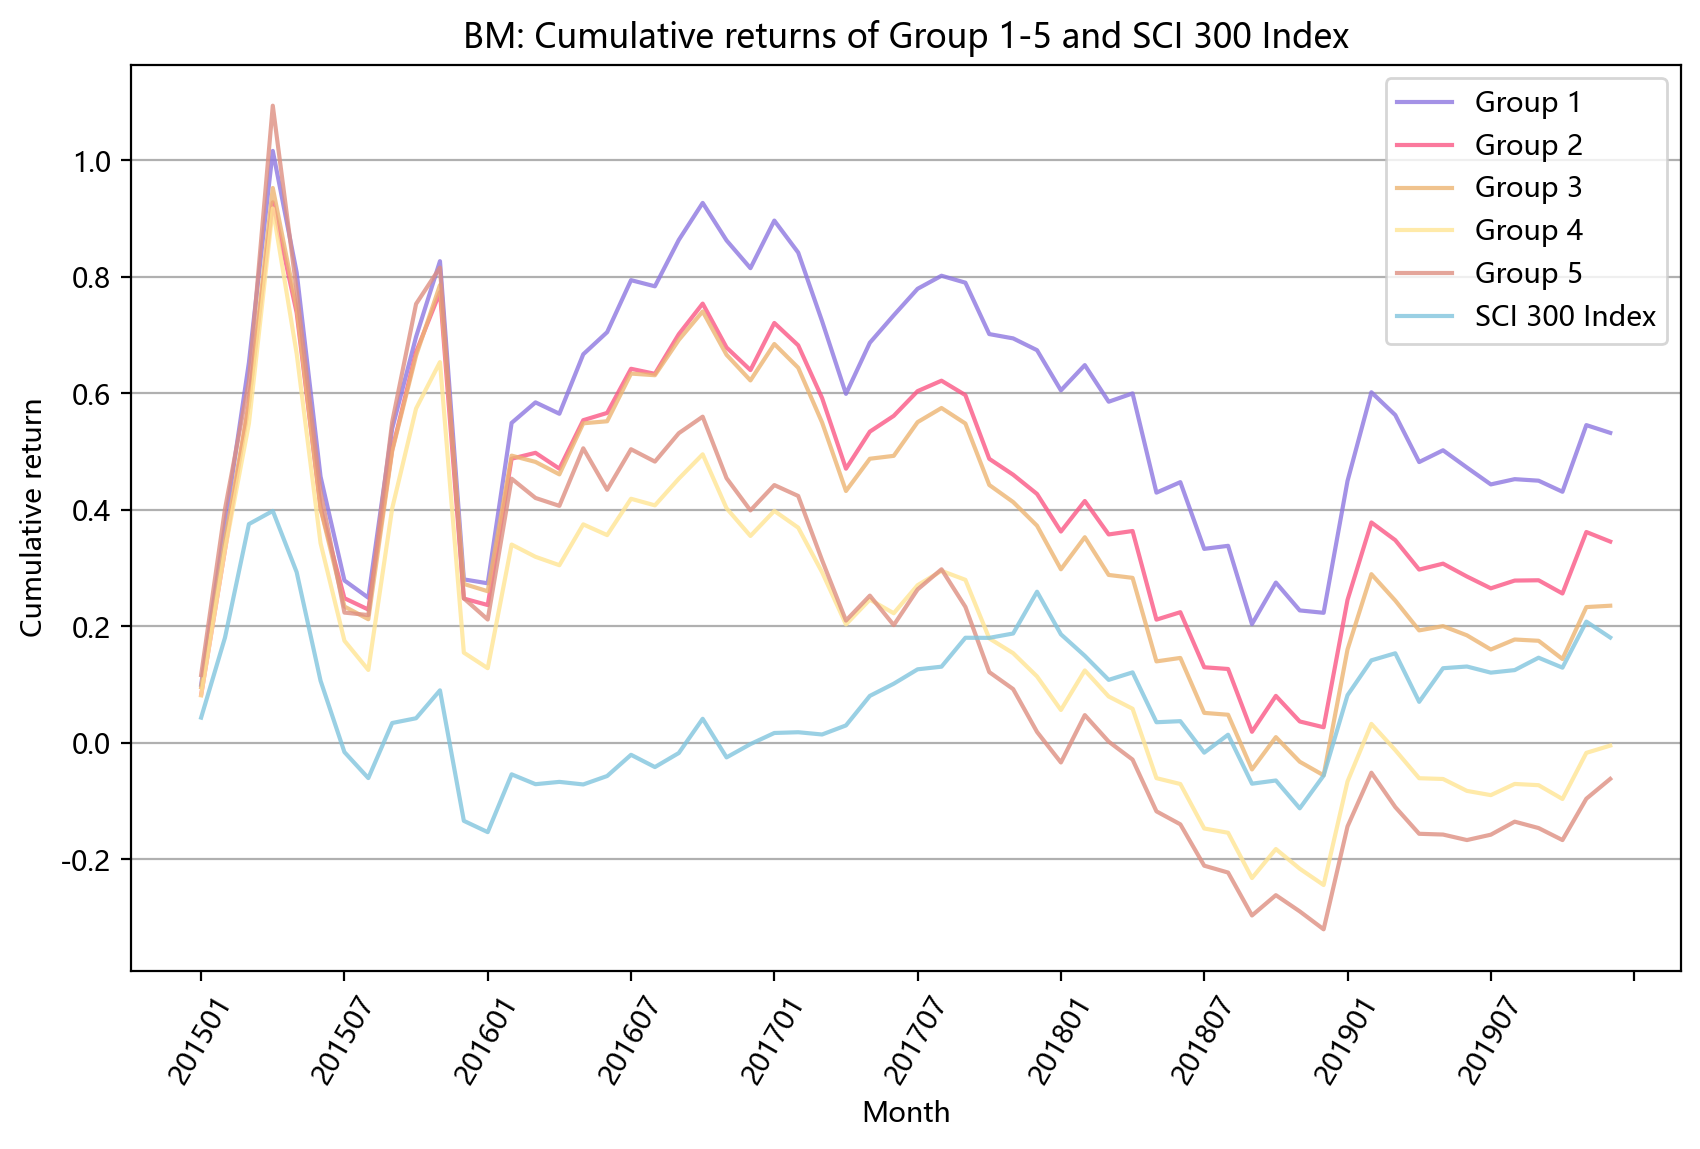

In [12]:
# This is plotting the results from the benchmark linear regression model
x = dfa[dfa['class_label']==1].year_month.values
x = [str(x) for x in x]
ys = []
for i in range(M):
    yi = dfa[dfa['class_label']==(i+1)].c_pct_chg.values
    ys.append(yi)
ys.append(dfa[dfa['class_label']==1].c_hs_300.values)

label_ys = []
for i in range(M):
    label_yi = 'Group {}'.format(i+1) 
    label_ys.append(label_yi)
label_ys.append('SCI 300 Index')

label_x = 'Month'
label_y = 'Cumulative return'
title = 'BM: Cumulative returns of Group 1-5 and SCI 300 Index'

fig = plt.figure(figsize=(10, 6), dpi=200)  # an empty figure with no Axes
plt.xticks(rotation=60)   
for i in range(len(label_ys)):
#     if i!=0:
    plt.plot(x, ys[i], label=label_ys[i], color=colors[i], alpha=0.8)  # etc.
plt.xlabel(label_x)
plt.ylabel(label_y)

# axis setting
ax=plt.gca()
tick_spacing = 6   
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

# background grid
plt.grid(axis="y")
plt.title(title)
plt.legend()

plt.show()



result_lines_BM = ys # should be changed every model
result_lines_BM.append(dfa[dfa['class_label']==1].c_pct_chg.values - dfa[dfa['class_label']==5].c_pct_chg.values)
pd.DataFrame(result_lines_BM).to_csv('result_lines_BM.csv', index=False)

### Machine Learning Model

In [13]:

# ------- Model name -------- #
# This is training our gradient boosting model which is used for both long-short and long strategies
model_name = 'Machine_Learnning_Model_One'
result_name = '{}_{}_{}_{}'.format(epoch_t0,len_train,if_industry_neutral, model_name) 

df_result1 = pd.DataFrame()
epoch_ts = list(df.year_month.sort_values().unique())
epoch_t0_idx = epoch_ts.index(epoch_t0) 

for epoch in trange(0, 60):
    print('----- EPOCH {}------'.format(epoch))
    epoch_t_train = epoch_ts[epoch_t0_idx-12+epoch:epoch_t0_idx+epoch] # epoch_t0 = 201001 
    epoch_t_pred = epoch_ts[epoch_t0_idx+epoch]
    df_train = df[df.year_month.apply(lambda x: x in epoch_t_train)].reset_index(drop=True)
    df_test = df[df.year_month == epoch_t_pred].reset_index(drop=True)
    print('Predicton month：', epoch_t_pred)
    print('Matrix shape：', df_train.shape, df_test.shape)
    
    # Delete stock that list less than 100 days
    a = pd.to_datetime(df_train.year_month, format='%Y%m')
    b = pd.to_datetime(df_train.list_date, format='%Y%m%d')
    df_train = df_train[a-b > timediff] 
    a = pd.to_datetime(df_test.year_month, format='%Y%m')
    b = pd.to_datetime(df_test.list_date, format='%Y%m%d')
    df_test = df_test[a-b > timediff] 
    
    # delete null target rows
    df_train = df_train[~df_train.target.isnull()]
    
    # label for splitting by quintile
    df_train['target_label'] = df_train.groupby('year_month').target.apply(lambda x: pd.qcut(x, q=qcut_q, labels=qcut_labels, duplicates='drop'))
    df_train = df_train[(df_train['target_label']==0) | (df_train['target_label']==1)] # take label 0 and 1 part
    

    mevtransformer = MedianExtremeValueTransformer()
    mevtransformer.fit(df_train[features])
    df_train[features] = mevtransformer.transform(df_train[features])
    df_test[features] = mevtransformer.transform(df_test[features])

    # deal with null data
    gvfiller= GroupValueFiller()
    gvfiller = gvfiller.fit(df_train)
    df_train = gvfiller.transform(df_train)
    df_test = gvfiller.transform(df_test)
    print('Null value：', df_train.isnull().any().sum(), df_test.isnull().any().sum())
    df_train.dropna(inplace=True) 
    df_test.dropna(inplace=True) 
    print('Null value：', df_train.isnull().any().sum(), df_test.isnull().any().sum())

    
    if if_industry_neutral=='idstn':
        idst_neutral= IndustryNeutral()
        idst_neutral = idst_neutral.fit(df_train)
        df_train = idst_neutral.transform(df_train)
        df_test = idst_neutral.transform(df_test)
    else:
        pass

    # standardization
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(df_train[features])
    df_train[features] = scaler.transform(df_train[features])
    df_test[features] = scaler.transform(df_test[features])


    X_train = df_train[features].values 
    X_test = df_test[features].values


    print('Xtrain and Xtest shape：', X_train.shape, X_test.shape)
    
    # get ytrain and ytest
    y_train = df_train['target'].copy() 
    y_test = df_test['target'].copy()
    
    
    
    # Model
    reg = ensemble.GradientBoostingRegressor() 
    
    model = reg.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    
    # Results of every month
    df_result = df_test[f_test].copy()
    df_result['y'] = y_test
    df_result['y_pred'] = y_pred
    df_result['y_rank'] = df_result.y.rank(ascending=False) 
    df_result['y_pred_rank'] = df_result.y_pred.rank(ascending=False) 
    df_result['y_rank_idst'] = df_result.groupby('industry').y_pred.rank(ascending=False) # order in every industry
    df_result['class_label'] = pd.qcut(df_result.y_rank_idst, q=q_class, labels=labels_class,duplicates='drop') # split by quintile
    df_result1 = df_result1.append(df_result)
    
    


# save result
df_result1.to_csv(result_name+'.csv', index=False)



df_result1 = pd.read_csv(result_name+'.csv')
# sort values
df_result1 = df_result1.sort_values(by=['year_month', 'class_label', 'y_rank_idst', 'industry', 'ts_code']).reset_index(drop=True)

# add the column Year
df_result1['year'] = df_result1.year_month.apply(lambda x: str(x)[:4]) # e.g. first 4 digits of 201001, which is 2010



# calculate means for 120 months*5class
dfa = df_result1.groupby(['year', 'year_month','class_label'])[['t_pct_chg', 't_hs300', 'y']].mean()
dfa.reset_index(inplace=True)


# cumulative return
dfb = dfa.groupby('class_label')['t_pct_chg', 't_hs300', 'y'].apply(lambda x: (x+1).cumprod()-1)
dfb.columns = ['c_pct_chg', 'c_hs_300', 'c_y']
dfa = dfa.join(dfb)

# sot values again and reset index
dfa = dfa.sort_values(by=['class_label', 'year', 'year_month']).reset_index(drop=True)




perform = {}

perform['Portfolio'] = []
for i in range(M):
    perform['Portfolio'].append('Group {}'.format(i+1))
perform['Portfolio'].append('SCI 300 Index')
perform['Portfolio'].append('Long-short Group')


# Annualized returns ---------------------------------------

perform['Annualized returns'] = []
for i in range(M):
    dfd = dfa[dfa['class_label']==(i+1)]
    total_r = dfd.c_pct_chg.values[-1] + 1
    total_m = dfd.shape[0]
    # Annualized returns
    perform['Annualized returns'].append(np.power(total_r , 12/total_m) - 1)    
    
# SCI 300 Index
dfd = dfa[dfa['class_label']==1]
total_r = dfd.c_hs_300.values[-1] + 1
total_m = dfd.shape[0]
perform['Annualized returns'].append(np.power(total_r , 12/total_m) - 1)

# Long-short Group
dfd = dfa[dfa['class_label']==1]
dfe = dfa[dfa['class_label']==5]
total_r = dfd.c_pct_chg.values[-1] - dfe.c_pct_chg.values[-1] + 1
total_m = dfd.shape[0]
perform['Annualized returns'].append(np.power(total_r , 12/total_m) - 1)


# Annualized volatility ------------------------------------

perform_idx = 'Annualized volatility'
perform[perform_idx]=[]
for i in range(M):
    dfd = dfa[dfa['class_label']==(i+1)]
    total_r = dfd.t_pct_chg.std() 
    total_m = dfd.shape[0]
    perform[perform_idx].append(np.power(total_r*total_r*12, 1/2))   
    
# SCI 300 Index
dfd = dfa[dfa['class_label']==1]
total_r = dfd.c_hs_300.std()
total_m = dfd.shape[0]
perform[perform_idx].append(np.power(total_r*total_r*12, 1/2))  

# Long-short Group
dfd = dfa[dfa['class_label']==1].reset_index(drop=True)
dfe = dfa[dfa['class_label']==5].reset_index(drop=True)
total_r = (dfd.t_pct_chg - dfe.t_pct_chg).std() 
total_m = dfd.shape[0]
perform[perform_idx].append(np.power(total_r*total_r*12, 1/2))


# Sharpe ratio ---------------------------------------------

perform_idx = 'Sharpe ratio'
perform[perform_idx]=[]
for i in range(M):
    dfd = dfa[dfa['class_label']==(i+1)]
    total_r = dfd.t_pct_chg.mean()
    total_std = dfd.t_pct_chg.std()
    perform[perform_idx].append(total_r/total_std*np.power(12,1/2))  
    
# SCI 300 Index
dfd = dfa[dfa['class_label']==1]
total_r = dfd.t_hs300.mean()
total_std = dfd.t_hs300.std()
perform[perform_idx].append(total_r/total_std*np.power(12,1/2))

# Long-short Group
dfd = dfa[dfa['class_label']==1].reset_index(drop=True)
dfe = dfa[dfa['class_label']==5].reset_index(drop=True)
total_r = (dfd.t_pct_chg - dfe.t_pct_chg).mean()
total_std = (dfd.t_pct_chg - dfe.t_pct_chg).std()
perform[perform_idx].append(total_r/total_std*np.power(12,1/2))   


# Max Drawdown ---------------------------------------------
def MaxDrawdown(return_list):
    '''Max drawdown'''
    i = np.argmax((np.maximum.accumulate(return_list) - return_list) / np.maximum.accumulate(return_list))  # end position
    if i == 0:
        return 0
    j = np.argmax(return_list[:i])  # starting position
    return (return_list[j] - return_list[i]) / (return_list[j])

perform_idx = 'Max drawdown'
perform[perform_idx]=[]
for i in range(M):
    dfd = dfa[dfa['class_label']==(i+1)]
    r_list = dfd.c_pct_chg.values + 1
    perform[perform_idx].append(MaxDrawdown(r_list))   

# SCI 300 Index
dfd = dfa[dfa['class_label']==1]
r_list = dfd.c_hs_300.values + 1
perform[perform_idx].append(MaxDrawdown(r_list))  

# Long-short Group
dfd = dfa[dfa['class_label']==1].reset_index(drop=True)
dfe = dfa[dfa['class_label']==5].reset_index(drop=True)
r_list = (dfd.c_pct_chg - dfe.c_pct_chg).values + 1
perform[perform_idx].append(MaxDrawdown(r_list))  


pd.DataFrame(perform).to_csv('result_table_MLM.csv', index=False)
pd.DataFrame(perform)


  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

----- EPOCH 0------
Predicton month： 201501
Matrix shape： (27053, 166) (2287, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (26931, 40) (2265, 40)


  2%|█▍                                                                                 | 1/60 [00:37<37:19, 37.96s/it]

----- EPOCH 1------
Predicton month： 201502
Matrix shape： (27074, 166) (2260, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (26930, 40) (2241, 40)


  3%|██▊                                                                                | 2/60 [01:18<38:05, 39.41s/it]

----- EPOCH 2------
Predicton month： 201503
Matrix shape： (27082, 166) (2278, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (26919, 40) (2265, 40)


  5%|████▏                                                                              | 3/60 [01:55<36:21, 38.28s/it]

----- EPOCH 3------
Predicton month： 201504
Matrix shape： (27111, 166) (2311, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (26936, 40) (2280, 40)


  7%|█████▌                                                                             | 4/60 [02:38<37:21, 40.03s/it]

----- EPOCH 4------
Predicton month： 201505
Matrix shape： (27167, 166) (2296, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (26989, 40) (2254, 40)


  8%|██████▉                                                                            | 5/60 [03:16<36:14, 39.53s/it]

----- EPOCH 5------
Predicton month： 201506
Matrix shape： (27223, 166) (2287, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (27046, 40) (2259, 40)


 10%|████████▎                                                                          | 6/60 [03:54<34:54, 38.79s/it]

----- EPOCH 6------
Predicton month： 201507
Matrix shape： (27261, 166) (2247, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (27056, 40) (2210, 40)


 12%|█████████▋                                                                         | 7/60 [04:38<35:59, 40.75s/it]

----- EPOCH 7------
Predicton month： 201508
Matrix shape： (27260, 166) (2241, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (27018, 40) (2185, 40)


 13%|███████████                                                                        | 8/60 [05:22<36:06, 41.65s/it]

----- EPOCH 8------
Predicton month： 201509
Matrix shape： (27251, 166) (2293, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (26953, 40) (2231, 40)


 15%|████████████▍                                                                      | 9/60 [06:02<35:05, 41.28s/it]

----- EPOCH 9------
Predicton month： 201510
Matrix shape： (27267, 166) (2336, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (26916, 40) (2312, 40)


 17%|█████████████▋                                                                    | 10/60 [06:41<33:47, 40.55s/it]

----- EPOCH 10------
Predicton month： 201511
Matrix shape： (27363, 166) (2408, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (27006, 40) (2408, 40)


 18%|███████████████                                                                   | 11/60 [07:18<32:10, 39.40s/it]

----- EPOCH 11------
Predicton month： 201512
Matrix shape： (27525, 166) (2464, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (27180, 40) (2464, 40)


 20%|████████████████▍                                                                 | 12/60 [07:56<31:10, 38.98s/it]

----- EPOCH 12------
Predicton month： 201601
Matrix shape： (27708, 166) (2474, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (27374, 40) (2473, 40)


 22%|█████████████████▊                                                                | 13/60 [08:32<29:53, 38.15s/it]

----- EPOCH 13------
Predicton month： 201602
Matrix shape： (27895, 166) (2461, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (27582, 40) (2459, 40)


 23%|███████████████████▏                                                              | 14/60 [09:12<29:34, 38.57s/it]

----- EPOCH 14------
Predicton month： 201603
Matrix shape： (28096, 166) (2488, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (27800, 40) (2467, 40)


 25%|████████████████████▌                                                             | 15/60 [09:48<28:24, 37.87s/it]

----- EPOCH 15------
Predicton month： 201604
Matrix shape： (28306, 166) (2466, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (28002, 40) (2452, 40)


 27%|█████████████████████▊                                                            | 16/60 [10:29<28:24, 38.73s/it]

----- EPOCH 16------
Predicton month： 201605
Matrix shape： (28461, 166) (2462, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (28174, 40) (2452, 40)


 28%|███████████████████████▏                                                          | 17/60 [11:05<27:12, 37.96s/it]

----- EPOCH 17------
Predicton month： 201606
Matrix shape： (28627, 166) (2486, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (28372, 40) (2469, 40)


 30%|████████████████████████▌                                                         | 18/60 [11:42<26:17, 37.57s/it]

----- EPOCH 18------
Predicton month： 201607
Matrix shape： (28826, 166) (2531, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (28582, 40) (2511, 40)


 32%|█████████████████████████▉                                                        | 19/60 [12:33<28:26, 41.63s/it]

----- EPOCH 19------
Predicton month： 201608
Matrix shape： (29110, 166) (2555, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (28883, 40) (2536, 40)


 33%|███████████████████████████▎                                                      | 20/60 [13:17<28:17, 42.43s/it]

----- EPOCH 20------
Predicton month： 201609
Matrix shape： (29424, 166) (2588, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (29234, 40) (2565, 40)


 35%|████████████████████████████▋                                                     | 21/60 [14:17<31:00, 47.71s/it]

----- EPOCH 21------
Predicton month： 201610
Matrix shape： (29719, 166) (2594, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (29568, 40) (2571, 40)


 37%|██████████████████████████████                                                    | 22/60 [15:15<32:05, 50.67s/it]

----- EPOCH 22------
Predicton month： 201611
Matrix shape： (29977, 166) (2636, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (29827, 40) (2610, 40)


 38%|███████████████████████████████▍                                                  | 23/60 [16:21<34:13, 55.49s/it]

----- EPOCH 23------
Predicton month： 201612
Matrix shape： (30205, 166) (2663, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (30029, 40) (2637, 40)


 40%|████████████████████████████████▊                                                 | 24/60 [17:11<32:19, 53.88s/it]

----- EPOCH 24------
Predicton month： 201701
Matrix shape： (30404, 166) (2675, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (30202, 40) (2644, 40)


 42%|██████████████████████████████████▏                                               | 25/60 [18:10<32:15, 55.29s/it]

----- EPOCH 25------
Predicton month： 201702
Matrix shape： (30605, 166) (2681, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (30373, 40) (2641, 40)


 43%|███████████████████████████████████▌                                              | 26/60 [19:11<32:16, 56.97s/it]

----- EPOCH 26------
Predicton month： 201703
Matrix shape： (30825, 166) (2724, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (30555, 40) (2672, 40)


 45%|████████████████████████████████████▉                                             | 27/60 [19:54<29:05, 52.88s/it]

----- EPOCH 27------
Predicton month： 201704
Matrix shape： (31061, 166) (2772, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (30760, 40) (2701, 40)


 47%|██████████████████████████████████████▎                                           | 28/60 [20:34<26:07, 48.97s/it]

----- EPOCH 28------
Predicton month： 201705
Matrix shape： (31367, 166) (2778, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (31009, 40) (2730, 40)


 48%|███████████████████████████████████████▋                                          | 29/60 [21:24<25:29, 49.34s/it]

----- EPOCH 29------
Predicton month： 201706
Matrix shape： (31683, 166) (2810, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (31287, 40) (2763, 40)


 50%|█████████████████████████████████████████                                         | 30/60 [22:28<26:50, 53.69s/it]

----- EPOCH 30------
Predicton month： 201707
Matrix shape： (32007, 166) (2868, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (31581, 40) (2806, 40)


 52%|██████████████████████████████████████████▎                                       | 31/60 [23:34<27:44, 57.41s/it]

----- EPOCH 31------
Predicton month： 201708
Matrix shape： (32344, 166) (2906, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (31876, 40) (2853, 40)


 53%|███████████████████████████████████████████▋                                      | 32/60 [24:15<24:28, 52.45s/it]

----- EPOCH 32------
Predicton month： 201709
Matrix shape： (32695, 166) (2979, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (32193, 40) (2932, 40)


 55%|█████████████████████████████████████████████                                     | 33/60 [24:56<22:01, 48.96s/it]

----- EPOCH 33------
Predicton month： 201710
Matrix shape： (33086, 166) (3011, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (32560, 40) (2960, 40)


 57%|██████████████████████████████████████████████▍                                   | 34/60 [25:48<21:36, 49.86s/it]

----- EPOCH 34------
Predicton month： 201711
Matrix shape： (33503, 166) (3050, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (32949, 40) (3006, 40)


 58%|███████████████████████████████████████████████▊                                  | 35/60 [26:50<22:15, 53.43s/it]

----- EPOCH 35------
Predicton month： 201712
Matrix shape： (33917, 166) (3076, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (33345, 40) (3033, 40)


 60%|█████████████████████████████████████████████████▏                                | 36/60 [27:52<22:24, 56.03s/it]

----- EPOCH 36------
Predicton month： 201801
Matrix shape： (34330, 166) (3110, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (33741, 40) (3067, 40)


 62%|██████████████████████████████████████████████████▌                               | 37/60 [28:47<21:22, 55.78s/it]

----- EPOCH 37------
Predicton month： 201802
Matrix shape： (34765, 166) (3114, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (34164, 40) (3066, 40)


 63%|███████████████████████████████████████████████████▉                              | 38/60 [29:40<20:11, 55.07s/it]

----- EPOCH 38------
Predicton month： 201803
Matrix shape： (35198, 166) (3108, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (34589, 40) (3077, 40)


 65%|█████████████████████████████████████████████████████▎                            | 39/60 [30:34<19:09, 54.76s/it]

----- EPOCH 39------
Predicton month： 201804
Matrix shape： (35582, 166) (3113, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (34994, 40) (3091, 40)


 67%|██████████████████████████████████████████████████████▋                           | 40/60 [31:31<18:25, 55.26s/it]

----- EPOCH 40------
Predicton month： 201805
Matrix shape： (35923, 166) (3172, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (35384, 40) (3155, 40)


 68%|████████████████████████████████████████████████████████                          | 41/60 [32:31<17:57, 56.70s/it]

----- EPOCH 41------
Predicton month： 201806
Matrix shape： (36317, 166) (3180, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (35809, 40) (3170, 40)


 70%|█████████████████████████████████████████████████████████▍                        | 42/60 [33:21<16:25, 54.76s/it]

----- EPOCH 42------
Predicton month： 201807
Matrix shape： (36687, 166) (3203, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (36216, 40) (3189, 40)


 72%|██████████████████████████████████████████████████████████▊                       | 43/60 [34:13<15:16, 53.91s/it]

----- EPOCH 43------
Predicton month： 201808
Matrix shape： (37022, 166) (3247, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (36599, 40) (3238, 40)


 73%|████████████████████████████████████████████████████████████▏                     | 44/60 [35:06<14:17, 53.62s/it]

----- EPOCH 44------
Predicton month： 201809
Matrix shape： (37363, 166) (3283, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (36984, 40) (3271, 40)


 75%|█████████████████████████████████████████████████████████████▌                    | 45/60 [35:55<13:01, 52.11s/it]

----- EPOCH 45------
Predicton month： 201810
Matrix shape： (37667, 166) (3307, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (37323, 40) (3298, 40)


 77%|██████████████████████████████████████████████████████████████▊                   | 46/60 [36:40<11:41, 50.13s/it]

----- EPOCH 46------
Predicton month： 201811
Matrix shape： (37963, 166) (3332, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (37661, 40) (3325, 40)


 78%|████████████████████████████████████████████████████████████████▏                 | 47/60 [37:26<10:34, 48.80s/it]

----- EPOCH 47------
Predicton month： 201812
Matrix shape： (38245, 166) (3349, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (37980, 40) (3338, 40)


 80%|█████████████████████████████████████████████████████████████████▌                | 48/60 [38:12<09:37, 48.09s/it]

----- EPOCH 48------
Predicton month： 201901
Matrix shape： (38518, 166) (3354, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (38285, 40) (3349, 40)


 82%|██████████████████████████████████████████████████████████████████▉               | 49/60 [39:00<08:49, 48.11s/it]

----- EPOCH 49------
Predicton month： 201902
Matrix shape： (38762, 166) (3361, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (38567, 40) (3353, 40)


 83%|████████████████████████████████████████████████████████████████████▎             | 50/60 [39:48<08:00, 48.06s/it]

----- EPOCH 50------
Predicton month： 201903
Matrix shape： (39009, 166) (3365, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (38854, 40) (3356, 40)


 85%|█████████████████████████████████████████████████████████████████████▋            | 51/60 [40:44<07:33, 50.42s/it]

----- EPOCH 51------
Predicton month： 201904
Matrix shape： (39266, 166) (3376, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (39133, 40) (3362, 40)


 87%|███████████████████████████████████████████████████████████████████████           | 52/60 [41:33<06:38, 49.80s/it]

----- EPOCH 52------
Predicton month： 201905
Matrix shape： (39529, 166) (3378, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (39404, 40) (3367, 40)


 88%|████████████████████████████████████████████████████████████████████████▍         | 53/60 [42:26<05:57, 51.00s/it]

----- EPOCH 53------
Predicton month： 201906
Matrix shape： (39735, 166) (3388, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (39616, 40) (3376, 40)


 90%|█████████████████████████████████████████████████████████████████████████▊        | 54/60 [43:16<05:04, 50.68s/it]

----- EPOCH 54------
Predicton month： 201907
Matrix shape： (39943, 166) (3395, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (39822, 40) (3384, 40)


 92%|███████████████████████████████████████████████████████████████████████████▏      | 55/60 [44:06<04:11, 50.26s/it]

----- EPOCH 55------
Predicton month： 201908
Matrix shape： (40135, 166) (3406, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (40017, 40) (3393, 40)


 93%|████████████████████████████████████████████████████████████████████████████▌     | 56/60 [44:56<03:20, 50.21s/it]

----- EPOCH 56------
Predicton month： 201909
Matrix shape： (40294, 166) (3413, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (40172, 40) (3405, 40)


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 57/60 [45:47<02:31, 50.59s/it]

----- EPOCH 57------
Predicton month： 201910
Matrix shape： (40424, 166) (3424, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (40306, 40) (3409, 40)


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 58/60 [46:38<01:41, 50.57s/it]

----- EPOCH 58------
Predicton month： 201911
Matrix shape： (40541, 166) (3424, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (40417, 40) (3424, 40)


 98%|████████████████████████████████████████████████████████████████████████████████▋ | 59/60 [47:32<00:51, 51.54s/it]

----- EPOCH 59------
Predicton month： 201912
Matrix shape： (40633, 166) (3425, 166)
Null value： 0 0
Null value： 0 0
Xtrain and Xtest shape： (40516, 40) (3425, 40)


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [48:24<00:00, 48.42s/it]


,Portfolio,Annualized returns,Annualized volatility,Sharpe ratio,Max drawdown
0,Group 1,0.091510,0.334616,0.426712,0.404276
1,Group 2,0.048503,0.327098,0.305409,0.487339
2,Group 3,0.025897,0.328377,0.239216,0.542170
3,Group 4,0.013204,0.342901,0.206175,0.595076
4,Group 5,-0.000895,0.378835,0.179928,0.656829
5,SCI 300 Index,0.034073,0.403138,0.262068,0.394308
6,Long-short Group,0.092139,0.097339,0.766615,0.093219


# Visualization of Gradient Boosting Model Prediction for each group relative to the index

In [28]:
x = dfa[dfa['class_label']==1].year_month.values
x = [str(x) for x in x]
ys = []
for i in range(M):
    yi = dfa[dfa['class_label']==(i+1)].c_pct_chg.values
    ys.append(yi)
ys.append(dfa[dfa['class_label']==1].c_hs_300.values)

label_ys = []
for i in range(M):
    label_yi = 'Group {}'.format(i+1) 
    label_ys.append(label_yi)
label_ys.append('SCI 300 Index')

label_x = 'Month'
label_y = 'Cumulative return'
title = 'MLM: Cumulative returns of Group 1-5 and SCI 300 Index' # should be changed every model

fig = plt.figure(figsize=(10, 6), dpi=200)  # an empty figure with no Axes
plt.xticks(rotation=60)   
for i in range(len(label_ys)):
#     if i!=0:
    plt.plot(x, ys[i], label=label_ys[i], color=colors[i], alpha=0.8)  # etc.
plt.xlabel(label_x)
plt.ylabel(label_y)

# axis setting
ax=plt.gca()
tick_spacing = 6   
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

# background grid
plt.grid(axis="y")
plt.title(title)
plt.legend()

plt.show()



result_lines_MLM = ys # should be changed every model
result_lines_MLM.append(dfa[dfa['class_label']==1].c_pct_chg.values - dfa[dfa['class_label']==5].c_pct_chg.values)
pd.DataFrame(result_lines_MLM).to_csv('result_lines_MLM.csv', index=False)

NameError: name 'dfa' is not defined

# Visualization of Long-Short Strategy with cumulative return


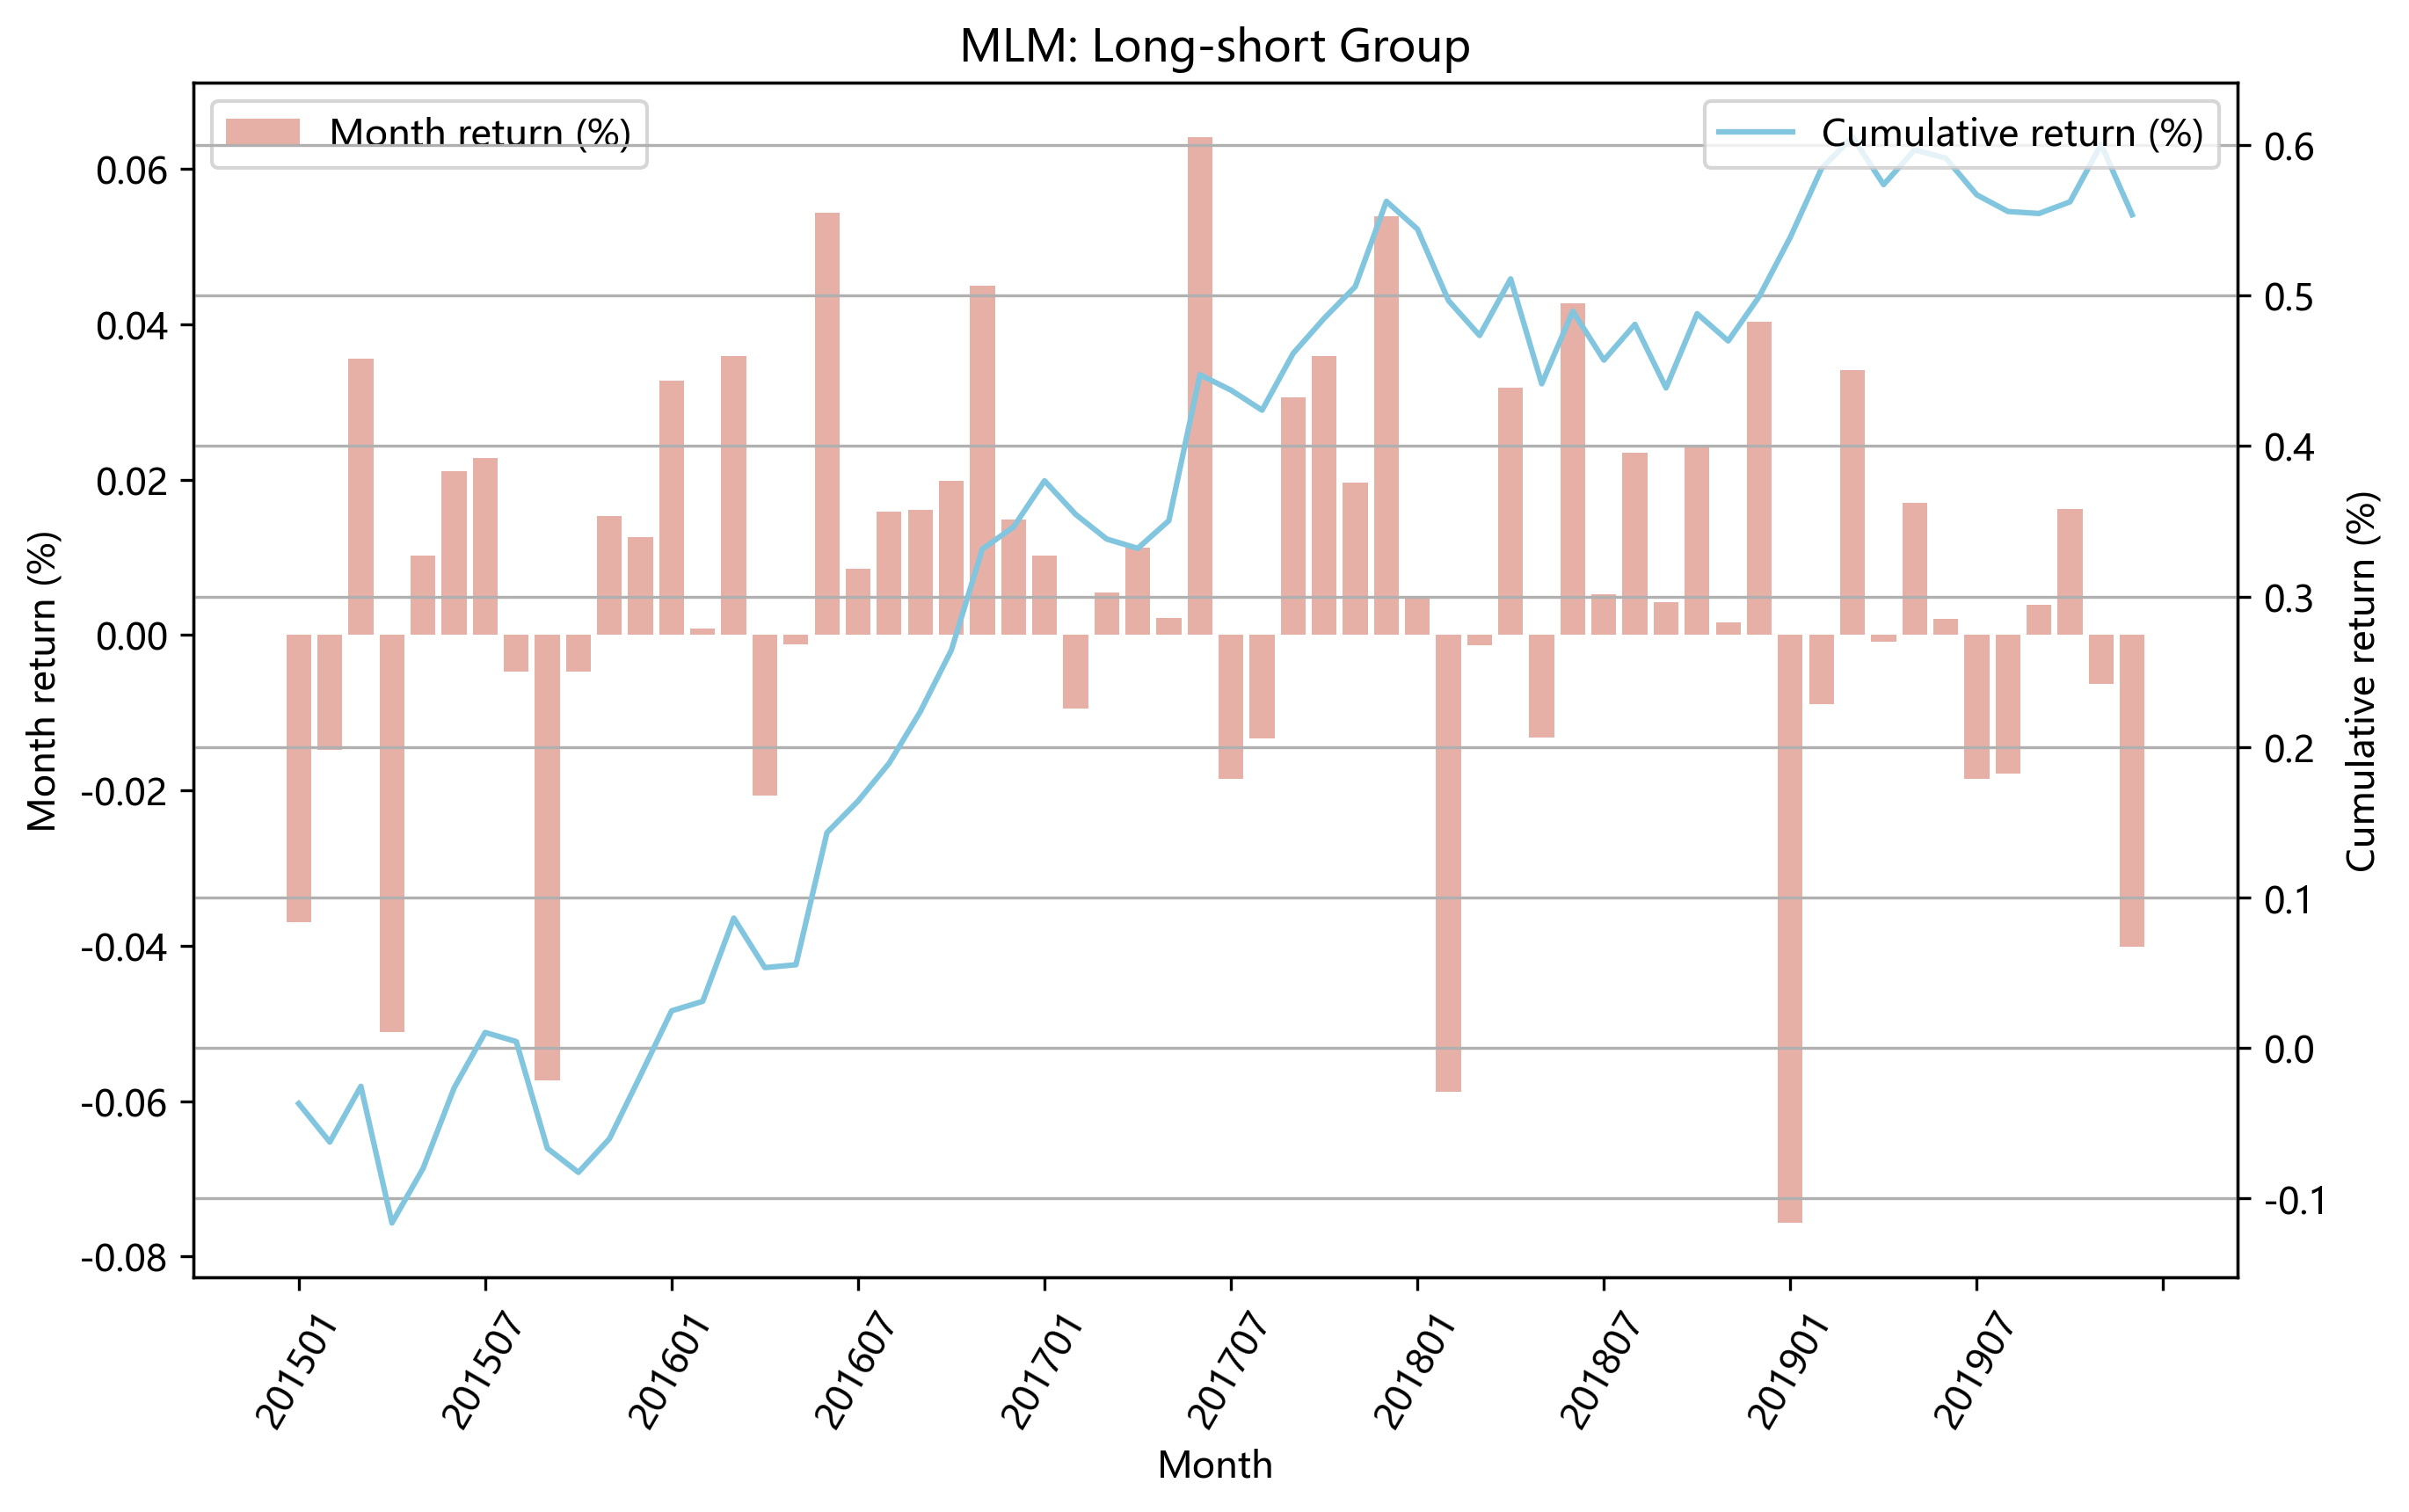

In [15]:
x = dfa[dfa['class_label']==1].year_month.values
x = [str(x) for x in x]
y1 = dfa[dfa['class_label']==1].t_pct_chg.values - dfa[dfa['class_label']==5].t_pct_chg.values
y2 = dfa[dfa['class_label']==1].c_pct_chg.values - dfa[dfa['class_label']==5].c_pct_chg.values
label_x = 'Month'
label_y1 = 'Month return'
label_y2 = 'Cumulative return'

color_y1 = colors[4]
color_y2 = colors[5]
title = 'MLM: Long-short Group'
label_y1 = 'Month return (%)'
label_y2 = 'Cumulative return (%)'

fig, ax1 = plt.subplots(figsize=(10, 6), dpi=300)
plt.xticks(rotation=60)   
ax2 = ax1.twinx()  # mirroring

lns1 = ax1.bar(x=x, height=y1, label=label_y1, color=color_y1, alpha=0.7)
lns2 = ax2.plot(x, y2, color=color_y2, ms=10, label=label_y2)

ax1.set_xlabel(label_x)  
ax1.set_ylabel(label_y1)  
ax2.set_ylabel(label_y2)  

ax1.grid(False)
ax2.grid(False)

tick_spacing = 6   
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title(title)
plt.grid(axis="y")

plt.show()

# 4. Conclusion
> We output the result data and plot our different strategies with different groups in Excel. 

## A. Benchmark Model
> Finally, the cumulative returns of SCI 300 and BM are compared as below:

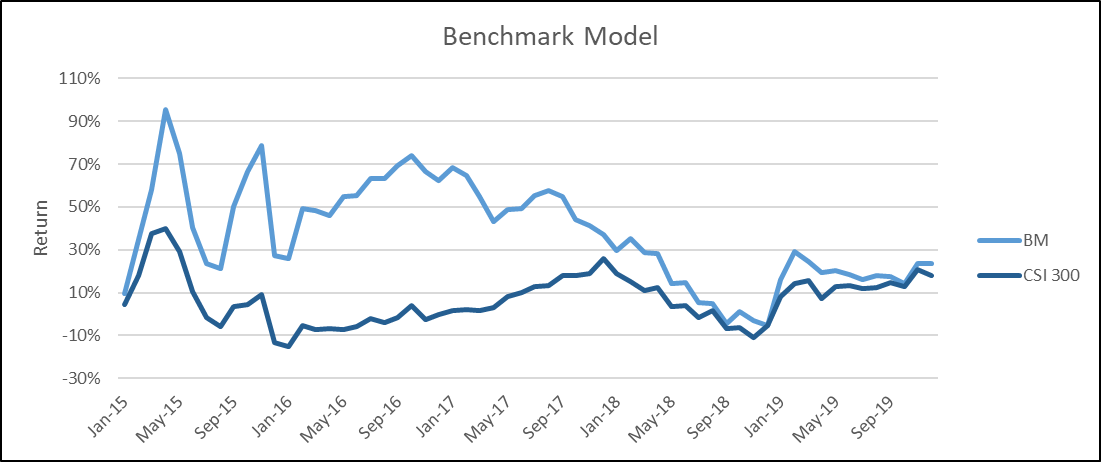

## B. Machine Learning Model 1 (MLM1): Long-short
> MLM1 and SCI 300 are as below:

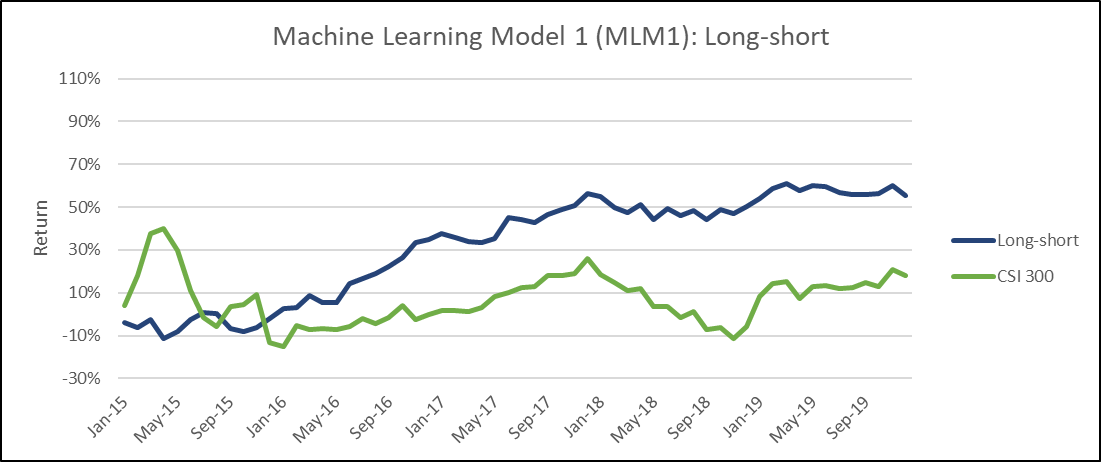

## C. Machine Learning Model 2 (MLM2): Long-only
> MLM2 and SCI 300 are as below:

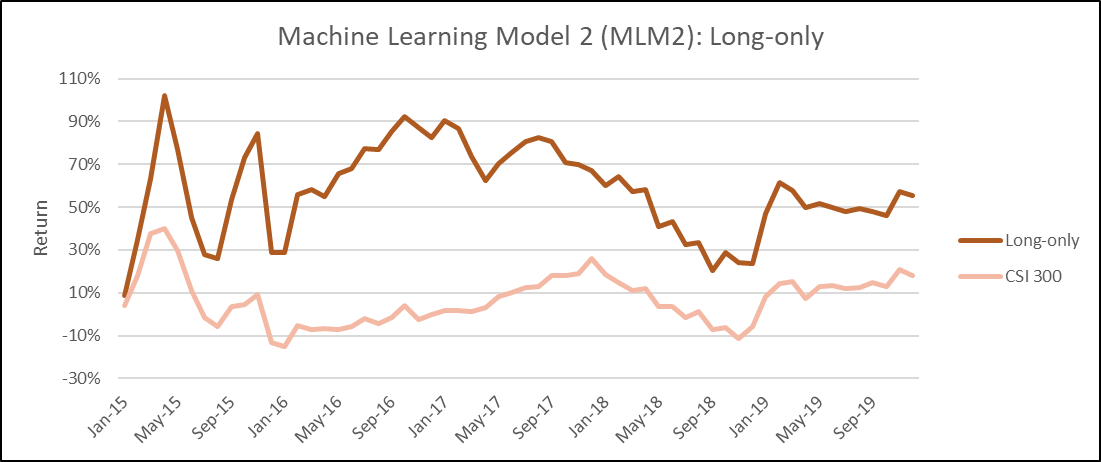

## D. Summary
> Now we put all of them together:


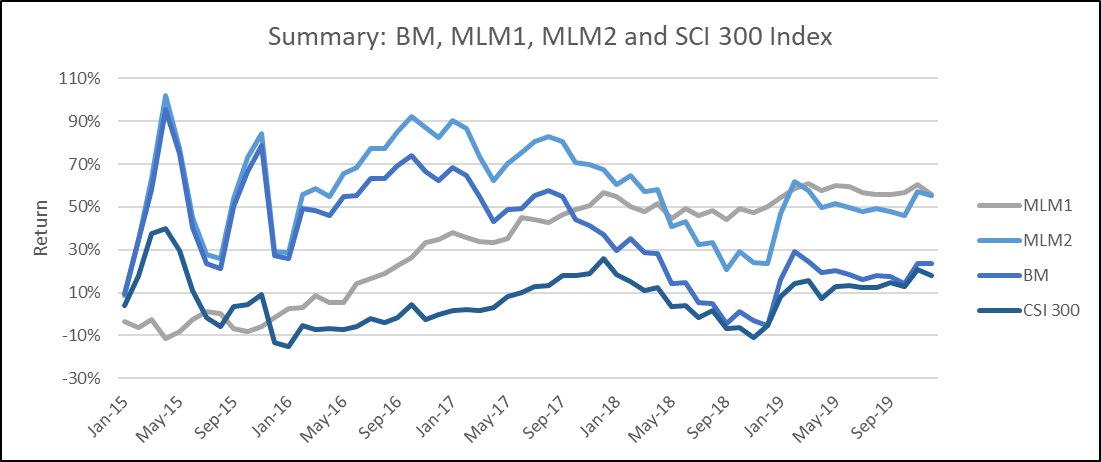

In [16]:
pd_MLM = pd.read_csv('result_table_MLM.csv')
pd_MLM = pd_MLM.iloc[[6,0], [0,1,3,4]].reset_index(drop = True)
pd_MLM['Portfolio'][1] = 'MLM2'
pd_MLM['Portfolio'][0] = 'MLM1'

pd_BM = pd.read_csv('result_table_BM.csv')
pd_BM = pd_BM.iloc[[2,5], [0,1,3,4]].reset_index(drop = True)
pd_BM['Portfolio'][0] = 'BM'

pd_Result_All = pd.concat([pd_MLM, pd_BM])
pd_Result_All = pd_Result_All.reset_index(drop = True)
pd_Result_All

,Portfolio,Annualized returns,Sharpe ratio,Max drawdown
0,MLM1,0.092139,0.766615,0.093219
1,MLM2,0.091510,0.426712,0.404276
2,BM,0.043214,0.289728,0.516309
3,SCI 300 Index,0.033832,0.261043,0.394296
